In [1]:
## Notebook to analyze the anode/cathode waveforms from the liquid purity monitor and calculate
## the outgassing rate

import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.append('../../WaveformAnalysis/')
import Dataset as ds
import datetime
from matplotlib.dates import DateFormatter

In [2]:
## path to data
data_path = '/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/nEXO/lifetime_analysis/data/20230804/'

## glob string for filenames to use
filename = 'LXe_C2700*.h5'

volume = 0.4 # volume of liquid xenon used, L 
Efield = 300 ## Efield, V/cm

anode_ch, cath_ch = 0, 1 ## channel numbers for anode and cathode

plot_title = "2023/08/04"

save_plots = True
plot_dir = '/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/nEXO/lifetime_analysis/plots/20230804/'
if( not os.path.exists(plot_dir) ):
    os.makedirs(plot_dir)   

In [3]:
## intialize the dataset object and import data
dset = ds.Dataset(data_path, Selection=filename)
channels = dset.InitializeChannels()
for filename in dset.Files:
    dset.ImportDataFromHDF5(filename, channels)

In [4]:
## get waveforms and baseline subtract
templates = []
for ii, ch in enumerate(channels):
    # print(" | Processing data in channel %d..." % (ch.ID))
    ch.GetSampling()
    ch.Amp = [x for _, x in sorted(zip(ch.TimeStamp, ch.Amp))]
    ch.Amp = np.array(ch.Amp)

    ch.FiltAmp = np.zeros_like(ch.Amp)
    ch.FiltAmp = ch.FilterWaveforms(ch.Amp,1e3, 2e5)

    ch.TimeStamp = np.array(sorted(ch.TimeStamp))

    ch.Amp = ch.SubtractBaseline(Data=ch.Amp)

    templates.append(ch.MakeTemplate(ch.Amp))

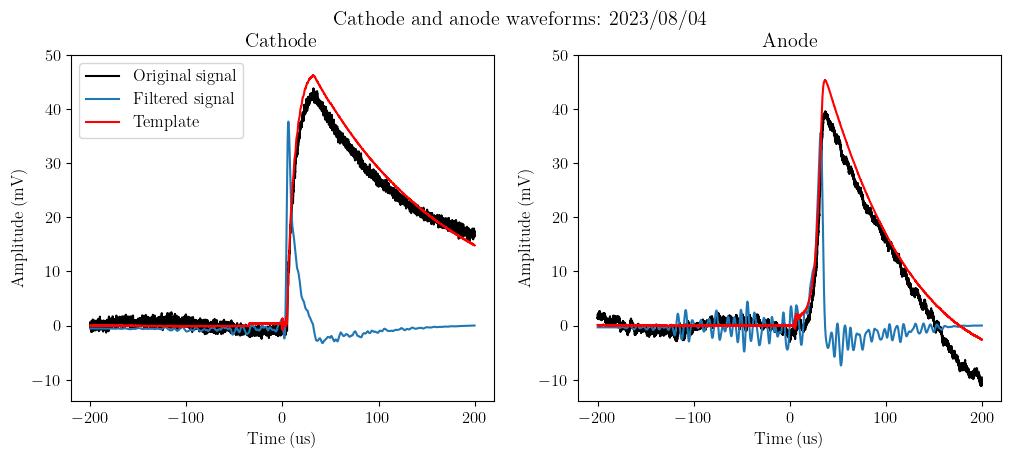

In [5]:
## make some plots to check data/filtering looks good
plt.figure(figsize=(12,4.5))

title_list = ['Cathode', 'Anode']

min_y_ax, max_y_ax = 0, 50
for i, chidx in enumerate([cath_ch, anode_ch]):
    ch = channels[chidx]
    plt.subplot(1,2,1+i)
    plt.plot(ch.Time, ch.Amp[0], 'k',label="Original signal")
    plt.plot(ch.Time, ch.FiltAmp[0], label="Filtered signal")
    plt.plot(ch.Time, templates[chidx], 'r', label="Template")

    plt.xlabel('Time (us)')
    plt.ylabel('Amplitude (mV)')
    plt.title(title_list[i])

    yy = plt.ylim()
    if yy[0] < min_y_ax:
        min_y_ax = yy[0]
    if yy[1] > max_y_ax:
        max_y_ax = yy[1]

## make equal autosized axes for both plots
for i, chidx in enumerate([cath_ch, anode_ch]):
    plt.subplot(1,2,1+i)
    if(i==0): plt.legend()
    plt.ylim(min_y_ax, max_y_ax)

plt.suptitle("Cathode and anode waveforms: " + plot_title)
if(save_plots):
    plt.savefig(plot_dir + "cathode_anode_waveforms.png")
plt.show()

In [6]:
## calculate drift time
drift_time_vec = []
for i in range(len(channels[cath_ch].FiltAmp)):
    cathode_max = channels[cath_ch].Time[np.argmax(channels[cath_ch].FiltAmp[i])]
    anode_max = channels[anode_ch].Time[np.argmax(channels[anode_ch].FiltAmp[i])]

    drift_time_vec.append(anode_max - cathode_max)

drift_time_vec = np.array(drift_time_vec)

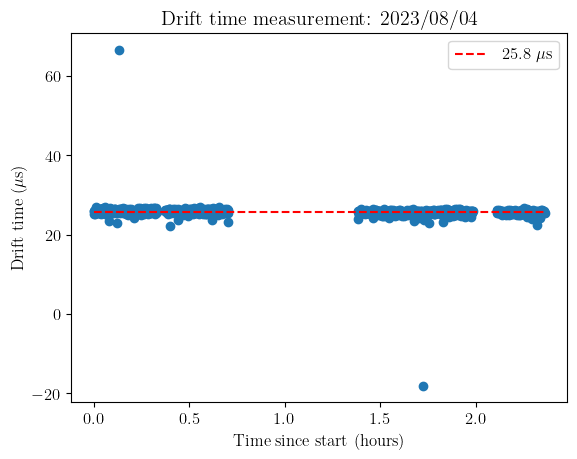

In [7]:
## plot drift time distribution
plt.figure()
time_since_start = np.array([(x - channels[cath_ch].TimeStamp[0]).total_seconds()/3600. for x in ch.TimeStamp])
plt.plot(time_since_start, drift_time_vec, 'o')
mean_drift_time = np.median(drift_time_vec)
plt.plot(time_since_start, np.ones_like(time_since_start)*mean_drift_time, 'r--', label="%.1f $\mu$s" % mean_drift_time)
plt.xlabel('Time since start (hours)')
plt.ylabel('Drift time ($\mu$s)')
plt.legend()
plt.title("Drift time measurement: " + plot_title)

if(save_plots):
    plt.savefig(plot_dir + "drift_time.png")

plt.show()

In [8]:
## now reconstruct the pulse amplitudes for each waveform two ways:
## 1) fitting to the template
## 2) Max of the filtered waveform

for ii, ch in enumerate(channels):

    ch.ReconstructFitAmplitude(ch.Amp, templates[ii]) 
    ch.ReconstructFiltAmplitude(ch.FiltAmp) 

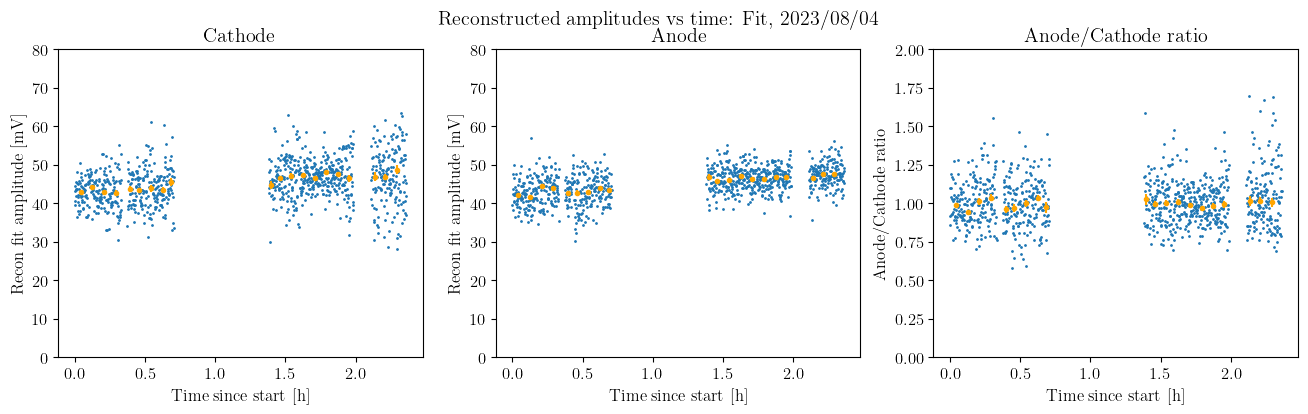

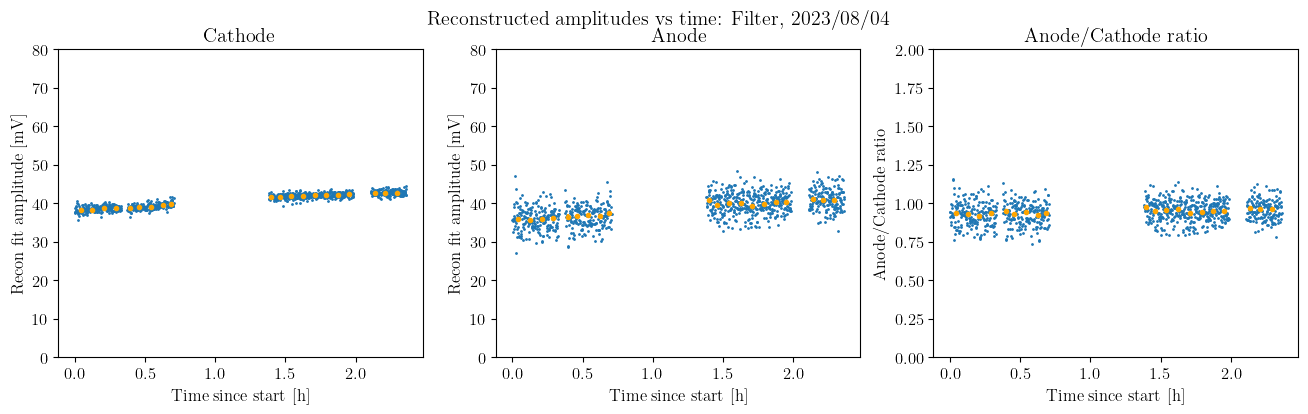

In [9]:
## Make some plots of the reconstructed amplitudesm rebinning to 5 minute intervals

rebin = 5/60. ## rebin to 5 minute intervals

amp_methods_to_use = ['Fit', 'Filter']
recon_ratios = []

for amp_method in amp_methods_to_use:
    plt.figure(figsize=(16,4))

    for i, chidx in enumerate([cath_ch, anode_ch]):
        ch = channels[chidx]

        if(amp_method == 'Fit'):
            recon_quant = ch.ReconAmpFit
        elif(amp_method == 'Filter'):
            recon_quant = ch.ReconAmpFilt
        else:
            print("Invalid amplitude reconstruction method")
            break

        plt.subplot(1,3,1+i)
        plt.plot(time_since_start, recon_quant, 'o', ms=1, label="Fit")

        tbins = np.arange(0, time_since_start[-1], rebin)
        for tidx in range(len(tbins)-1):
            idx = (time_since_start > tbins[tidx]) & (time_since_start < tbins[tidx+1]) & ~np.isnan(recon_quant)
            if np.sum(idx) == 0: continue
            plt.errorbar(np.mean(time_since_start[idx]), np.median(recon_quant[idx]), yerr=np.std(recon_quant[idx])/np.sqrt(np.sum(idx)), ms=3, fmt='o', color='orange')

        plt.xlabel('Time since start [h]')
        plt.ylabel("Recon fit amplitude [mV]")
        plt.title(title_list[i])
        plt.ylim(0,80)

    ## now do the ratio
    plt.subplot(1,3,3)
    ch_anode, ch_cathode = channels[anode_ch], channels[cath_ch]

    if(amp_method == 'Fit'):
        recon_quant = ch_anode.ReconAmpFit/ch_cathode.ReconAmpFit
    elif(amp_method == 'Filter'):
        recon_quant = ch_anode.ReconAmpFilt/ch_cathode.ReconAmpFilt


    plt.plot(time_since_start, recon_quant, 'o', ms=1, label="Fit")

    ReconAmpRatio = []
    for tidx in range(len(tbins)-1):
        idx = (time_since_start > tbins[tidx]) & (time_since_start < tbins[tidx+1]) & ~np.isnan(recon_quant)
        if np.sum(idx) == 0: continue
        yvals = recon_quant[idx]
        plt.errorbar(np.mean(time_since_start[idx]), np.median(yvals), yerr=np.std(yvals)/np.sqrt(np.sum(idx)), ms=3, fmt='o', color='orange')

        ReconAmpRatio.append([np.mean(time_since_start[idx]), np.median(yvals), np.std(yvals)/np.sqrt(np.sum(idx))])


    plt.xlabel('Time since start [h]')
    plt.ylabel("Anode/Cathode ratio")
    plt.title("Anode/Cathode ratio")
    plt.ylim(0, 2)
    plt.suptitle("Reconstructed amplitudes vs time: %s, " % amp_method + plot_title)

    ReconAmpRatio = np.array(ReconAmpRatio)
    recon_ratios.append(ReconAmpRatio)

    if(save_plots):
        plt.savefig(plot_dir + "recon_amps_%s.png" % amp_method)

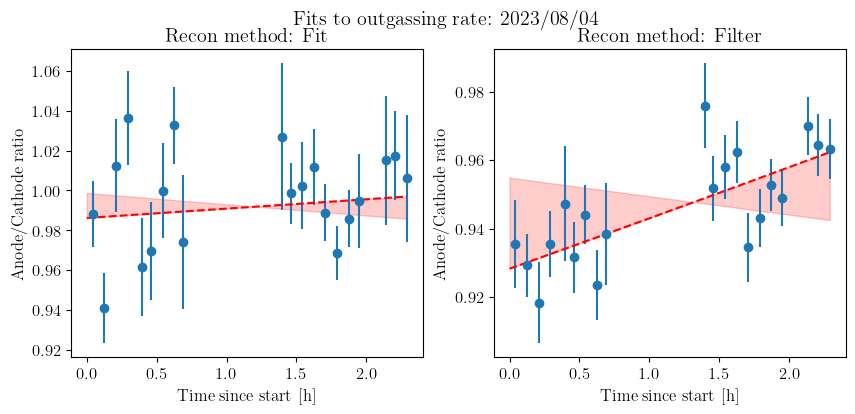

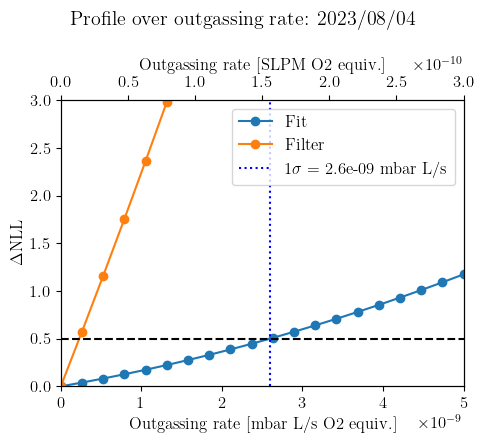

In [12]:
## Now fit the rebinned data to get the outgassing rate
hours_to_s = 3600.0
mus_to_s = 1e-6

## constraint term to use for alpha (differs slightly due to the methods, but should be near 1)
alpha_constraint_term = [[1, 0.02],
                         [0.95, 0.02]]

k = dset.GetO2RateConstant(Efield)

profile_vals = np.linspace(0,5e-9, 20) ## values to profile over for outgassing rate, in ppb O2/s

fit_figure = plt.figure(figsize=(10,4))
profile_figure = plt.figure(figsize=(5,4.5))

profile_y_range = [0,3]

for j,amp_method in enumerate(amp_methods_to_use):

    plt.figure(fit_figure.number)
    plt.subplot(1,2,1+j)
    plt.errorbar(recon_ratios[j][:,0], recon_ratios[j][:,1], yerr=recon_ratios[j][:,2], fmt='o')

    tvals = np.linspace(0, recon_ratios[j][-1,0], 1000)
    popt, pcov, profile, min_fit, max_fit = dset.FitOutgassingRate(recon_ratios[j][:,0]*hours_to_s, recon_ratios[j][:,1], recon_ratios[j][:,2], 
                                                                   Efield, mean_drift_time*mus_to_s, profile_vals=profile_vals, tvals=tvals*hours_to_s,
                                                                   volume=volume, alpha_mu=alpha_constraint_term[j][0], alpha_err=alpha_constraint_term[j][1])

    ## plot the best fit
    plt.figure(fit_figure.number)
    plt.plot(tvals, dset.LifetimeFunction(tvals*hours_to_s, *popt, k, mean_drift_time*mus_to_s, volume), 'r--', 
             label="Fit: %.2f $\pm$ %.2f" % (popt[0], np.sqrt(pcov[0,0])))
    plt.fill_between(tvals, min_fit, max_fit, color='r', alpha=0.2)
    plt.xlabel('Time since start [h]')
    plt.ylabel("Anode/Cathode ratio")
    plt.title("Recon method: " + amp_method)

    plt.figure(profile_figure.number)
    plt.plot(profile[:,0], profile[:,1], 'o-', label=amp_method)

    if(amp_method == 'Fit'):
        crossing = np.interp(0.5, profile[:,1], profile[:,0])


plt.figure(profile_figure.number)
plt.xlabel("Outgassing rate [mbar L/s O2 equiv.]")
plt.ylabel("$\Delta$NLL")
plt.plot(profile_vals, np.ones_like(profile_vals)*0.5, 'k--')
plt.ylim(profile_y_range)
plt.xlim(profile_vals[0], profile_vals[-1])
plt.plot([crossing, crossing], profile_y_range, 'b:', label=r"$1\sigma$ = %.1e mbar L/s" % crossing)
plt.legend()

## SLPM on top:
ax2 = plt.gca().twiny()
ax2.set_xlabel("Outgassing rate [SLPM O2 equiv.]")
mbarLps_to_SLPM = 1e-3 * 60
ax2.set_xlim(profile_vals[0]*mbarLps_to_SLPM, profile_vals[-1]*mbarLps_to_SLPM)

plt.figure(fit_figure.number)
plt.suptitle("Fits to outgassing rate: " + plot_title)

if(save_plots):                         
    plt.savefig(plot_dir + "outgassing_fit.png")

plt.figure(profile_figure.number)
plt.suptitle("Profile over outgassing rate: " + plot_title)
plt.tight_layout()

if(save_plots):                         
    plt.savefig(plot_dir + "outgassing_profile.png")